In [1]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

# Human Data Science - Course Project

## Costruzione del dataset
L'obiettivo è la creazione di un dataset o più dataset contenenti dati riguardo al crimine e fattori socio-economici che possono influenzare il crimine stesso per ogni paese dell'Unione Europea.


I dati riguardo i crimini commessi sono forniti da [Eurostat](https://ec.europa.eu/eurostat/databrowser/view/crim_off_cat__custom_7891721/default/table?lang=en), [Explanatory Texts](https://ec.europa.eu/eurostat/cache/metadata/en/crim_off_cat_esms.htm)

In [2]:
df = pandas.read_table('data/crime/crim_off_cat.tsv')  #ok

display(df)

,"freq,iccs,unit,geo\TIME_PERIOD",2016,2017,2018,2019,2020,2021
0,"A,ICCS0101,P_HTHAB,AT",0.56,0.70,0.83,0.84,0.61,0.66
1,"A,ICCS0101,P_HTHAB,BE",1.55,1.74,1.68,1.27,1.26,1.26
2,"A,ICCS0101,P_HTHAB,BG",1.10,1.34,1.30,1.14,0.95,1.27
3,"A,ICCS0101,P_HTHAB,CY",1.30,0.82,1.62,1.48,1.69,1.56
4,"A,ICCS0101,P_HTHAB,CZ",0.62,0.38,0.52,0.76,0.53,0.43
...,...,...,...,...,...,...,...
501,"A,ICCS09051,P_HTHAB,PL",1.28,1.52,1.20,1.30,2.30,2.37
502,"A,ICCS09051,P_HTHAB,PT",0.10,0.10,0.06,0.08,0.05,0.03
503,"A,ICCS09051,P_HTHAB,RO",5.32,4.93,3.52,2.81,2.53,3.07
504,"A,ICCS09051,P_HTHAB,SI",0.05,0.05,0.19,0.24,0.05,0.19


### Legenda
ICCS = International Classification of crime for statistical purposes
Geo = Geopolitical entity 
Unit = Unit of measure (Per 100 000 inhabitants)
Freq = Time frequency (A = Annual)

Nel dataset sono presenti record per 20 tipi di crimini diversi, purtroppo per alcuni crimini i dati erano incompleti, mancanti o completamente non presenti per alcuni paesi. Per questo motivo sono stati selezionati solo alcuni tipi di crimini per ogni paese:
- Intentional Homicide
- Serious Assalt (Dati mancanti per l'Ungheria)
- Sexual Violence
- Stupro (Dati mancanti per l'Italia) (?)
- Robbery
- theft
- Corruption (Alcuni valori sono stati interpolati linearmente)

I dati sono forniti per ogni paese dell'Unione Europea, per ogni anno dal 2016 al 2021.

In [3]:
split = df["freq,iccs,unit,geo\\TIME_PERIOD"].str.split(",", expand=True)
split.columns = ["freq", "iccs", "unit", "geo"]
split.drop(columns=["freq", "unit"], inplace=True)
split = split[["geo", "iccs"]]

df = pd.concat([df, split], axis=1)
df.drop(columns=["freq,iccs,unit,geo\\TIME_PERIOD"], inplace=True)
df = df.iloc[:, ::-1]
df.rename(columns=lambda x: x.strip(), inplace=True)

In [4]:
# Rename rows with the name of the country
geo_dict = {
    "BE": "Belgium",
    "BG": "Bulgaria",
    "CZ": "Czechia",
    "DK": "Denmark",
    "DE": "Germany",
    "EE": "Estonia",
    "IE": "Ireland",
    "EL": "Greece",
    "ES": "Spain",
    "FR": "France",
    "HR": "Croatia",
    "IT": "Italy",
    "CY": "Cyprus",
    "LV": "Latvia",
    "LT": "Lithuania",
    "LU": "Luxembourg",
    "HU": "Hungary",
    "MT": "Malta",
    "NL": "Netherlands",
    "AT": "Austria",
    "PL": "Poland",
    "PT": "Portugal",
    "RO": "Romania",
    "SI": "Slovenia",
    "SK": "Slovakia",
    "FI": "Finland",
    "SE": "Sweden",
}

df["geo"] = df["geo"].map(geo_dict)
display(df)

,iccs,geo,2021,2020,2019,2018,2017,2016
0,ICCS0101,Austria,0.66,0.61,0.84,0.83,0.70,0.56
1,ICCS0101,Belgium,1.26,1.26,1.27,1.68,1.74,1.55
2,ICCS0101,Bulgaria,1.27,0.95,1.14,1.30,1.34,1.10
3,ICCS0101,Cyprus,1.56,1.69,1.48,1.62,0.82,1.30
4,ICCS0101,Czechia,0.43,0.53,0.76,0.52,0.38,0.62
...,...,...,...,...,...,...,...,...
501,ICCS09051,Poland,2.37,2.30,1.30,1.20,1.52,1.28
502,ICCS09051,Portugal,0.03,0.05,0.08,0.06,0.10,0.10
503,ICCS09051,Romania,3.07,2.53,2.81,3.52,4.93,5.32
504,ICCS09051,Slovenia,0.19,0.05,0.24,0.19,0.05,0.05


In [5]:
# Select ICCS0101
omicidio_df = df[df["iccs"] == "ICCS0101"].drop(columns=["iccs"])
omicidio_df.set_index("geo", inplace=True)
omicidio_df = omicidio_df.iloc[:, ::-1]
display(omicidio_df)

omicidio_df = omicidio_df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
omicidio_df["Total"] = omicidio_df.sum(axis=1)

country_most_common = omicidio_df["Total"].idxmax()
total_most_common = omicidio_df["Total"].max()

print(
    f"The country with the most common crime is {country_most_common} with {total_most_common} crimes per 100.000 inhabitants")

omicidio_df.drop(columns=["Total"], inplace=True)

omicidio_df.reset_index(inplace=True)

omicidio_df = omicidio_df.melt(id_vars=["geo"], var_name="year", value_name="homicides")

display(omicidio_df)

,2016,2017,2018,2019,2020,2021
geo,,,,,,
Austria,0.56,0.70,0.83,0.84,0.61,0.66
Belgium,1.55,1.74,1.68,1.27,1.26,1.26
Bulgaria,1.10,1.34,1.30,1.14,0.95,1.27
Cyprus,1.30,0.82,1.62,1.48,1.69,1.56
Czechia,0.62,0.38,0.52,0.76,0.53,0.43
Germany,0.91,0.89,0.76,0.71,0.86,0.76
Denmark,0.93,1.06,0.93,0.91,0.88,0.72
Estonia,2.51,2.20,1.90,1.74,2.78,1.35
Greece,0.75,0.72,0.88,0.71,0.68,0.83


The country with the most common crime is Latvia with 31.249999999999996 crimes per 100.000 inhabitants


,geo,year,homicides
0,Austria,2016,0.56
1,Belgium,2016,1.55
2,Bulgaria,2016,1.10
3,Cyprus,2016,1.30
4,Czechia,2016,0.62
...,...,...,...
157,Portugal,2021,0.80
158,Romania,2021,0.99
159,Sweden,2021,1.09
160,Slovenia,2021,0.43


In [6]:
# df = df.melt(id_vars=["geo", "iccs"], var_name="year", value_name="value")
display(df)
# df.to_csv("data/crime/crim_off_cat.csv", index=False)

,iccs,geo,2021,2020,2019,2018,2017,2016
0,ICCS0101,Austria,0.66,0.61,0.84,0.83,0.70,0.56
1,ICCS0101,Belgium,1.26,1.26,1.27,1.68,1.74,1.55
2,ICCS0101,Bulgaria,1.27,0.95,1.14,1.30,1.34,1.10
3,ICCS0101,Cyprus,1.56,1.69,1.48,1.62,0.82,1.30
4,ICCS0101,Czechia,0.43,0.53,0.76,0.52,0.38,0.62
...,...,...,...,...,...,...,...,...
501,ICCS09051,Poland,2.37,2.30,1.30,1.20,1.52,1.28
502,ICCS09051,Portugal,0.03,0.05,0.08,0.06,0.10,0.10
503,ICCS09051,Romania,3.07,2.53,2.81,3.52,4.93,5.32
504,ICCS09051,Slovenia,0.19,0.05,0.24,0.19,0.05,0.05


Ora il dataset è composto da 4 colonne:
- geo: nome del paese
- iccs: tipo di crimine
- anno: anno (2016-2021)
- value: numero di crimini per ogni 100.000 abitanti

cosa posso aggiungere? fattori socioecomomici quali dati trovare?

- interpolazione lineare per i dati di tipo b (break in the series)


In [7]:
# Interpolate linearly the data with type b (break in the series)
# 1) Sostituisce i valori contententi la stringa 'b' con None
# 2) Interpola linearmente i valori None
# 3) Resetta l'indice
def clean_interpolate(df, index):
    df.set_index(index, inplace=True)
    df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
    df = df.applymap(lambda x: None if 'b' in str(x) else x)
    df = df.interpolate(method='linear', axis=1, limit_direction='both')
    df.reset_index(inplace=True)
    return df


# Convert the data to the format: per 100.000 inhabitants
def convert_to_ht(population_df, df):
    population_df.set_index("geo", inplace=True)
    df.set_index("geo", inplace=True)

    df = df.div(100)
    df = df.mul(population_df, axis=0) / 100000

    df.reset_index(inplace=True)
    population_df.reset_index(inplace=True)

    return df

### Dataset popolazione
[Population on 1 January](https://ec.europa.eu/eurostat/databrowser/view/tps00001__custom_7848350/default/table?lang=en)

- Time: 2016-2021

### Flags
- b: break in time series
- ep: estimated, provisional
- p: provisional
- e: estimated

In [8]:
population_df = pandas.read_table('data/population/tps00001.tsv')

In [9]:
split = population_df["freq,indic_de,geo\\TIME_PERIOD"].str.split(",", expand=True)
split.drop(columns=[0, 1], inplace=True)
split.columns = ["geo"]

population_df = pd.concat([population_df, split], axis=1)
population_df.drop(columns=["freq,indic_de,geo\\TIME_PERIOD"], axis=1, inplace=True)
population_df = population_df.iloc[:, ::-1]
population_df.rename(columns=lambda x: x.strip(), inplace=True)
population_df["geo"] = population_df["geo"].map(geo_dict)

# Clean and interpolate the data
population_df = clean_interpolate(population_df, "geo")
display(population_df)

,geo,2021,2020,2019,2018,2017,2016
0,Austria,8932664.0,8901064.0,8858775.0,8822267.0,8772865.0,8700471.0
1,Belgium,11554767.0,11522440.0,11455519.0,11398589.0,11351727.0,11311117.0
2,Bulgaria,6916548.0,6951482.0,7000039.0,7050034.0,7101859.0,7153784.0
3,Cyprus,896007.0,888005.0,875899.0,864236.0,854802.0,848319.0
4,Czechia,10693939.0,10693939.0,10649800.0,10610055.0,10578820.0,10553843.0
5,Germany,83155031.0,83166711.0,83019213.0,82792351.0,82521653.0,82175684.0
6,Denmark,5840045.0,5822763.0,5806081.0,5781190.0,5748769.0,5707251.0
7,Estonia,1330068.0,1328976.0,1324820.0,1319133.0,1315635.0,1315944.0
8,Greece,10678632.0,10718565.0,10724599.0,10741165.0,10768193.0,10783748.0
9,Spain,47398695.0,47332614.0,46937060.0,46658447.0,46528024.0,46440099.0


Interpolazione per i dati con parametro p, 
Cosa fare invece quando si hanno dati con flag?
- e: estimated
- p: provisional
- ep: estimated, provisional
Continuare con l'interpolazione?

### Altro dataset: Persone a rischio di povertà o esclusione sociale
[People at rick of poverty or social exclusion](https://ec.europa.eu/eurostat/databrowser/view/sdg_01_10__custom_7836001/default/table?lang=en)

- Age: Less than 18 years
- Time: 2016-2021
- Sex: Total
- Unit:  percentage 

In [10]:
poverty_df = pandas.read_table('data/sdg/sdg_01_10.tsv')
display(poverty_df)

,"freq,sex,age,unit,geo\TIME_PERIOD",2016,2017,2018,2019,2020,2021
0,"A,T,Y_LT18,PC,AT",20.5,22.7,21.6,20.1,21.9,22.8
1,"A,T,Y_LT18,PC,BE",23.5,24.2,23.5,23.0 b,22.0,20.5
2,"A,T,Y_LT18,PC,BG",47.3 b,42.4,33.5,35.8,35.5,33.0
3,"A,T,Y_LT18,PC,CY",23.2,21.7,20.5,20.3,19.0,19.2
4,"A,T,Y_LT18,PC,CZ",16.4,14.3,13.0,13.0,12.9,13.3
5,"A,T,Y_LT18,PC,DE",20.6,18.6,17.5,15.4,22.3 b,23.7
6,"A,T,Y_LT18,PC,DK",14.0,15.1,15.4,13.8,13.4 b,14.0
7,"A,T,Y_LT18,PC,EE",19.7,18.8,17.0,19.7,17.4,17.4
8,"A,T,Y_LT18,PC,EL",37.2,36.5,34.1,31.2,30.8,32.0
9,"A,T,Y_LT18,PC,ES",33.7,31.9,30.5,31.0,31.6,33.4


In [11]:
split = poverty_df["freq,sex,age,unit,geo\\TIME_PERIOD"].str.split(",", expand=True)
split.drop(columns=[0, 1, 2, 3], inplace=True)
split.columns = ["geo"]

poverty_df = pd.concat([poverty_df, split], axis=1)
poverty_df.drop(columns=["freq,sex,age,unit,geo\\TIME_PERIOD"], axis=1, inplace=True)
poverty_df = poverty_df.iloc[:, ::-1]
poverty_df.rename(columns=lambda x: x.strip(), inplace=True)
poverty_df["geo"] = poverty_df["geo"].map(geo_dict)

Interopolazione lineare per i dati di tipo b (break in the series)

In [12]:
poverty_df = clean_interpolate(poverty_df, "geo")

display(poverty_df)

,geo,2021,2020,2019,2018,2017,2016
0,Austria,22.8,21.90,20.10,21.6,22.7,20.5
1,Belgium,20.5,22.00,22.75,23.5,24.2,23.5
2,Bulgaria,33.0,35.50,35.80,33.5,42.4,42.4
3,Cyprus,19.2,19.00,20.30,20.5,21.7,23.2
4,Czechia,13.3,12.90,13.00,13.0,14.3,16.4
5,Germany,23.7,19.55,15.40,17.5,18.6,20.6
6,Denmark,14.0,13.90,13.80,15.4,15.1,14.0
7,Estonia,17.4,17.40,19.70,17.0,18.8,19.7
8,Greece,32.0,30.80,31.20,34.1,36.5,37.2
9,Spain,33.4,31.60,31.00,30.5,31.9,33.7


I dati sono stati interpolati linearmente, ma non è detto che sia la scelta migliore.

I dati sono fortini in percentuale alla popolazione locale del paese. È necessaraio effettuare una normalizzazione per avere un confronto tra i paesi, portando quindi tutti i dati nel formato: ogni 100.000 abitanti.

In [13]:
poverty_df = convert_to_ht(population_df, poverty_df)

poverty_df = poverty_df.melt(id_vars=["geo"], var_name="year", value_name="poverty")

display(poverty_df)

,geo,year,poverty
0,Austria,2021,20.366474
1,Belgium,2021,23.687272
2,Bulgaria,2021,22.824608
3,Cyprus,2021,1.720333
4,Czechia,2021,14.222939
...,...,...,...
157,Portugal,2016,28.438658
158,Romania,2016,110.659276
159,Sweden,2016,19.406503
160,Slovenia,2016,2.993073


In [14]:
omicidio_df["geo"] = omicidio_df["geo"].map(geo_dict)

res = pd.merge(omicidio_df, poverty_df, on=["geo", "year"])
#res.to_csv("data/crime/res.csv", index=False)
display(res)

,geo,year,homicides,poverty


### Altro dataset: NEET, Not in Education, Employment or Training

[Young people neither in employment nor in education and training by sex (NEET)](https://ec.europa.eu/eurostat/databrowser/view/sdg_08_20__custom_7848499/default/table?lang=en)

- Age: 15-29 years
- Time: 2016-2021
- Unit: percentage

In [15]:
neet_df = pandas.read_table('data/sdg/sdg_08_20.tsv')

display(neet_df)

,"freq,sex,age,unit,geo\TIME_PERIOD",2016,2017,2018,2019,2020,2021
0,"A,T,Y15-29,PC_POP,AT",9.3,8.8,8.8,8.6,9.9,9.4
1,"A,T,Y15-29,PC_POP,BE",12.2,11.8 b,11.4,11.2,11.3,10.1 b
2,"A,T,Y15-29,PC_POP,BG",22.4,18.9,18.2,16.7,18.2,17.6
3,"A,T,Y15-29,PC_POP,CY",18.0,17.6,14.9,14.1,15.3,15.4
4,"A,T,Y15-29,PC_POP,CZ",11.1,10.0,9.5,9.8,11.0,10.9
5,"A,T,Y15-29,PC_POP,DE",10.0,9.6,9.0,8.6,9.6 b,9.5
6,"A,T,Y15-29,PC_POP,DK",8.4 b,9.8 b,9.6,9.6,10.2,8.3
7,"A,T,Y15-29,PC_POP,EE",13.3,10.5,11.5,9.7,11.1,11.2
8,"A,T,Y15-29,PC_POP,EL",21.9,21.0,19.2,17.5,18.5,17.2
9,"A,T,Y15-29,PC_POP,ES",18.1,16.4,15.3,14.9,17.3,14.1 d


In [16]:
split = neet_df["freq,sex,age,unit,geo\\TIME_PERIOD"].str.split(",", expand=True)
split.drop(columns=[0, 1, 2, 3], inplace=True)
split.columns = ["geo"]

neet_df = pd.concat([neet_df, split], axis=1)
neet_df.drop(columns=["freq,sex,age,unit,geo\\TIME_PERIOD"], axis=1, inplace=True)
neet_df = neet_df.iloc[:, ::-1]
neet_df.rename(columns=lambda x: x.strip(), inplace=True)
neet_df["geo"] = neet_df["geo"].map(geo_dict)

# Clean and interpolate the data
neet_df = clean_interpolate(neet_df, "geo")
# Convert to per 100.000 inhabitants
neet_df = convert_to_ht(population_df, neet_df)

neet_df = neet_df.melt(id_vars=["geo"], var_name="year", value_name="neet")
display(neet_df)

,geo,year,neet
0,Austria,2021,8.396704
1,Belgium,2021,13.056887
2,Bulgaria,2021,12.173124
3,Cyprus,2021,1.379851
4,Czechia,2021,11.656394
...,...,...,...
157,Portugal,2016,13.236902
158,Romania,2016,48.018222
159,Sweden,2016,6.600181
160,Slovenia,2016,1.919695


### Altro dataset: Tasso di occupazione
[Employment rates by sex, age and educational attainment level (%)](https://ec.europa.eu/eurostat/databrowser/view/lfsa_ergaed__custom_7848656/default/table?lang=en)

- Age: 20-64 years
- Time: 2016-2021
- Unit: percentage
- ISCED 2011 levels

In [17]:
employment_df = pandas.read_table('data/population/lfsa_ergaed.tsv')

display(employment_df)

,"freq,unit,sex,age,isced11,geo\TIME_PERIOD",2016,2017,2018,2019,2020,2021
0,"A,PC,T,Y20-64,TOTAL,AT",74.8,75.4,76.2,76.8,75.5,75.6 b
1,"A,PC,T,Y20-64,TOTAL,BE",67.7,68.5 b,69.7,70.5,70.0,70.6 b
2,"A,PC,T,Y20-64,TOTAL,BG",67.7,71.3,72.4,75.0,73.4,73.2 b
3,"A,PC,T,Y20-64,TOTAL,CY",68.7,70.8,73.9,75.7,74.9,75.9 b
4,"A,PC,T,Y20-64,TOTAL,CZ",76.7,78.5,79.9,80.3,79.7,80.0 b
5,"A,PC,T,Y20-64,TOTAL,DE",78.6,79.2,79.9,80.6,79.2 b,79.4 b
6,"A,PC,T,Y20-64,TOTAL,DK",76.0 b,76.6 b,77.5,78.3,77.8,79.1 b
7,"A,PC,T,Y20-64,TOTAL,EE",76.4,78.3,79.1,79.7,78.2,79.3 b
8,"A,PC,T,Y20-64,TOTAL,EL",56.2,57.8,59.5,61.2,61.1,62.6 b
9,"A,PC,T,Y20-64,TOTAL,ES",63.9,65.5,67.0,68.0,65.7,67.7 bd


# Costruzione del o dei dataset finali per l'analisi

In [18]:
# Costruzione del dataset riguardo il crimine intentional homicide
# I dati riguardo il crimine intentional homicide non hanno bisogno di essere interpolati

# controlla meglio orine degli anni !!! 

homicide_df = df[df["iccs"] == "ICCS0101"].drop(columns=["iccs"])
homicide_df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))

homicide_df = homicide_df.melt(id_vars=["geo"], var_name="year", value_name="homicides")

homicide_df = homicide_df.merge(poverty_df, on=["geo", "year"])
homicide_df = homicide_df.merge(neet_df, on=["geo", "year"])

display(homicide_df)



,geo,year,homicides,poverty,neet
0,Austria,2021,0.66,20.366474,8.396704
1,Belgium,2021,1.26,23.687272,13.056887
2,Bulgaria,2021,1.27,22.824608,12.173124
3,Cyprus,2021,1.56,1.720333,1.379851
4,Czechia,2021,0.43,14.222939,11.656394
...,...,...,...,...,...
157,Portugal,2016,0.64,28.438658,13.236902
158,Romania,2016,1.25,110.659276,48.018222
159,Sweden,2016,1.08,19.406503,6.600181
160,Slovenia,2016,0.48,2.993073,1.919695


In [19]:
# Adding theft to the dataset

theft_df = df[df["iccs"] == "ICCS0502"].drop(columns=["iccs"])
theft_df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))

theft_df = theft_df.melt(id_vars=["geo"], var_name="year", value_name="theft")

homicide_df = homicide_df.merge(theft_df, on=["geo", "year"])

display(homicide_df)



,geo,year,homicides,poverty,neet,theft
0,Austria,2021,0.66,20.366474,8.396704,819.61
1,Belgium,2021,1.26,23.687272,13.056887,1428.70
2,Bulgaria,2021,1.27,22.824608,12.173124,353.28
3,Cyprus,2021,1.56,1.720333,1.379851,58.82
4,Czechia,2021,0.43,14.222939,11.656394,248.45
...,...,...,...,...,...,...
157,Portugal,2016,0.64,28.438658,13.236902,863.57
158,Romania,2016,1.25,110.659276,48.018222,466.08
159,Sweden,2016,1.08,19.406503,6.600181,3810.73
160,Slovenia,2016,0.48,2.993073,1.919695,1036.44


<Axes: >

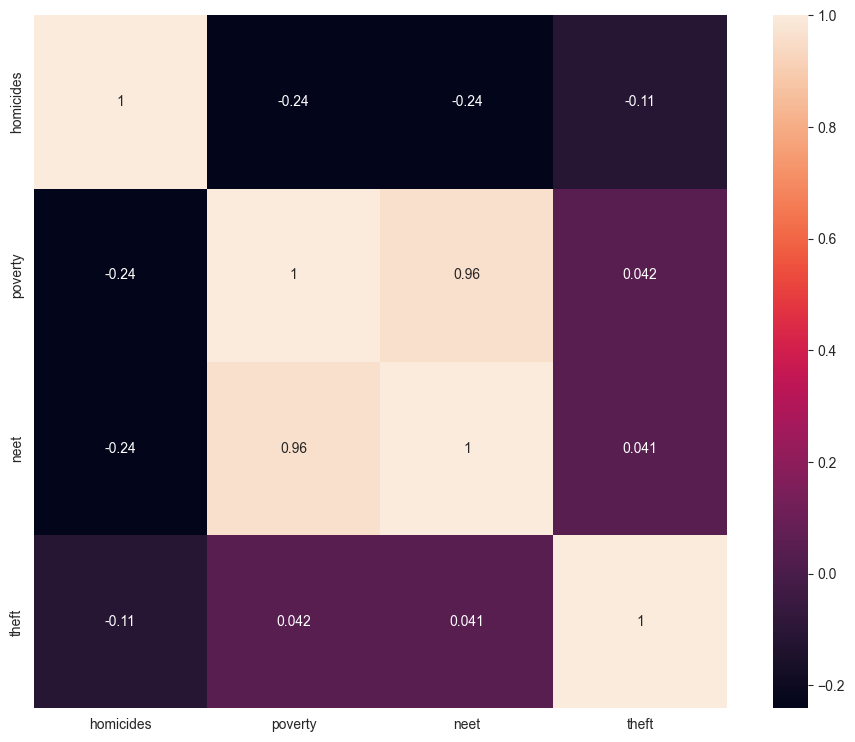

In [20]:
# Correlation matrix
corrmat = homicide_df[["homicides", "poverty", "neet", "theft"]].corr()

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corrmat, annot=True, square=True)